# Merging objects using machine learning

The `ObjectMerger` is a Random Forest Classifier part of the [apoc library](https://github.com/haesleinhuepf/apoc) that can learn which labels to merge and which not. It allows post-processing label images after objects have been (intentionally or not) oversegmented.

In [1]:
import apoc
from skimage.io import imread, imshow
import pyclesperanto_prototype as cle
import numpy as np

A common example can be derived from an image showing intensities in cell membranes.

cl.OCLArray([[4496., 5212., 6863., ..., 2917., 2680., 2642.],
       [4533., 5146., 7555., ..., 2843., 2857., 2748.],
       [4640., 6082., 8452., ..., 3372., 3039., 3128.],
       ...,
       [1339., 1403., 1359., ..., 4458., 4314., 4795.],
       [1473., 1560., 1622., ..., 3967., 4531., 4204.],
       [1380., 1368., 1649., ..., 3091., 3558., 3682.]], dtype=float32)
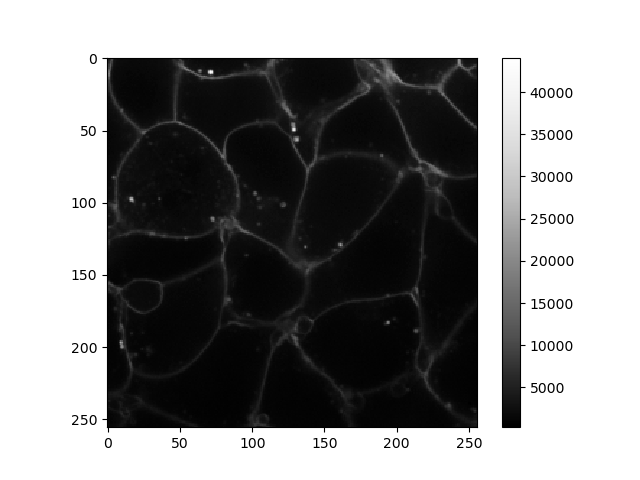
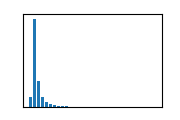

In [2]:
image = imread('../../data/membrane2d.tif')
cle.asarray(image)

As the membranes have different intensity depending on the region in the image, we need to correct for this first.

cl.OCLArray([[0.8514066 , 1.0200942 , 1.3921092 , ..., 0.6749894 , 0.6340478 ,
        0.6390664 ],
       [0.8397066 , 0.9866097 , 1.5033678 , ..., 0.6544611 , 0.6719634 ,
        0.6603491 ],
       [0.8410301 , 1.1425375 , 1.6502894 , ..., 0.7734034 , 0.7116847 ,
        0.747907  ],
       ...,
       [0.6833182 , 0.70865285, 0.6797715 , ..., 1.5903093 , 1.5137495 ,
        1.6566108 ],
       [0.7665792 , 0.8030892 , 0.8264799 , ..., 1.3939476 , 1.5649658 ,
        1.4287568 ],
       [0.73148733, 0.71694326, 0.85501015, ..., 1.0721965 , 1.2123575 ,
        1.2338016 ]], dtype=float32)
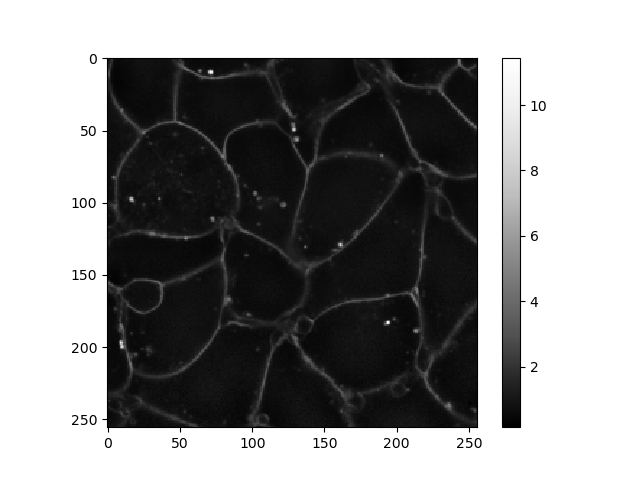
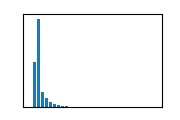

In [3]:
background_subtracted = cle.divide_by_gaussian_background(image, sigma_x=10, sigma_y=10)
background_subtracted

For technical reasons it is also recommeded to turn the intensity image into an image of type integer. Therefore, normalization might be necessary. It is important that images used for training and images used for prediction have intensities in the same range.

cl.OCLArray([[ 1,  1,  1, ...,  5,  5,  5],
       [ 1,  1,  1, ...,  5,  5,  5],
       [ 1,  1,  1, ...,  5,  5,  5],
       ...,
       [49, 49, 49, ..., 54, 54, 54],
       [49, 49, 49, ..., 54, 54, 54],
       [49, 49, 49, ..., 54, 54, 54]], dtype=uint32)
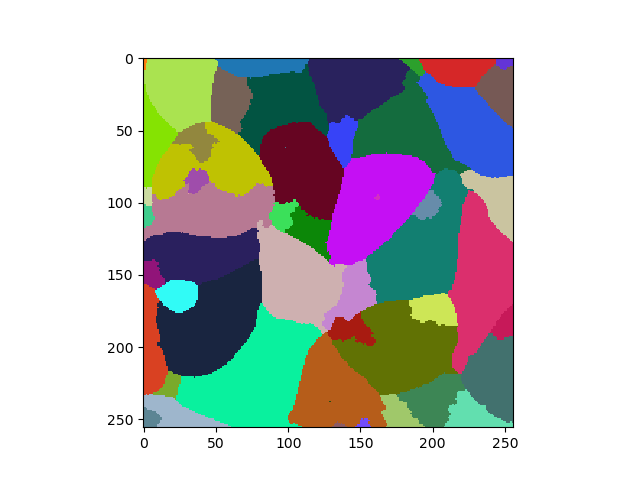

In [4]:
oversegmented = imread("../../data/membrane2d_oversegmented.tif")
cle.asarray(oversegmented).astype(np.uint32)

An annotation serves telling the algorithm which segmented objects should be merged and which not.

cl.OCLArray([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint32)
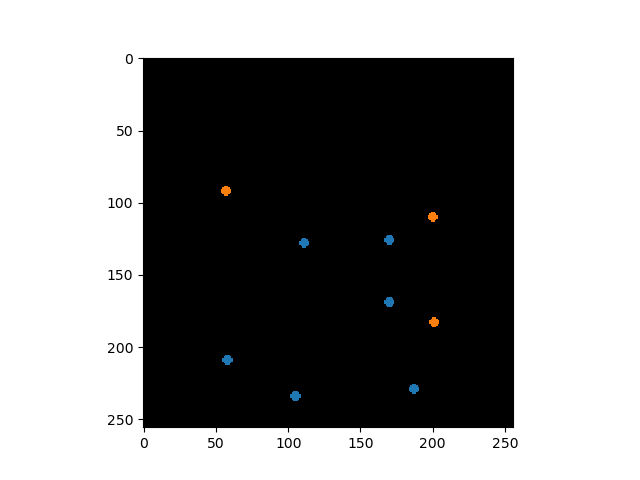

In [5]:
annotation = imread("../../data/membrane2d_merge_annotation.tif")
cle.asarray(annotation).astype(np.uint32)

For visualization purposes, we can overlay the annotation with the membrane image.

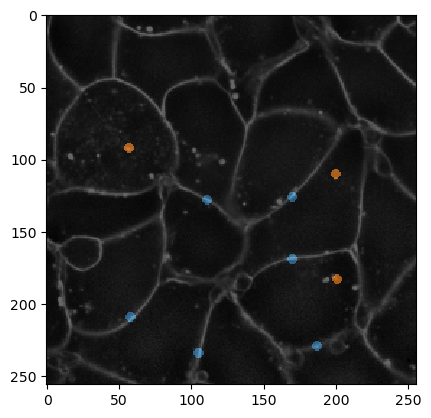

In [6]:
cle.imshow(background_subtracted, max_display_intensity=4, continue_drawing=True)
cle.imshow(annotation, alpha=0.6, labels=True)

To show more closely what needs to be annotated, we also overlay the label-edge image and the annotation. Note that the edges which are not supposed to be merged are small dots always carefully only annotating two objects (that should not be merged). 

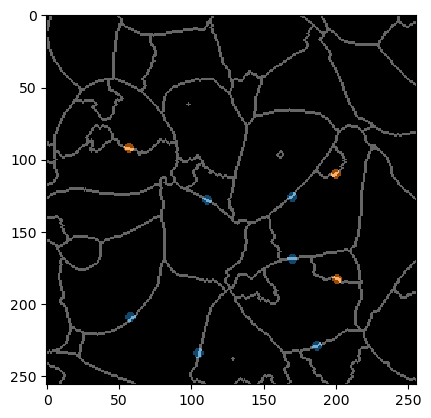

In [7]:
cle.imshow(cle.detect_label_edges(oversegmented), continue_drawing=True)
cle.imshow(annotation, alpha=0.6, labels=True)

## Training the merger

The `LabelMerger` can be trained using three features:
* `touch_portion`: The relative amount an object touches another. E.g. in a symmetric, honey-comb like tissue, neighboring cells have a touch-portion of `1/6` to each other.
* `touch_count`: The number of pixels where object touch. When using this parameter, make sure that images used for training and prediction have the same voxel size. 
* `mean_touch_intensity`: The mean average intensity between touching objects. If a cell is over-segmented, there are multiple objects found within that cell. The area where these objects touch has a lower intensity than the area where two cells touch. Thus, they can be differentiated. Normalizing the image as shown above is key.
* `centroid_distance`: The distance (in pixels or voxels) between centroids of labeled objects. 

Note: most features are recommended to be used in isotropic images only.

In [8]:
feature_definition = "touch_portion mean_touch_intensity"

classifier_filename = "label_merger.cl"

apoc.erase_classifier(classifier_filename)
classifier = apoc.ObjectMerger(opencl_filename=classifier_filename)

classifier.train(features=feature_definition,
                 labels=oversegmented,
                 sparse_annotation=annotation,
                 image=background_subtracted) 

cl.OCLArray([[ 1,  1,  1, ...,  5,  5,  5],
       [ 1,  1,  1, ...,  5,  5,  5],
       [ 1,  1,  1, ...,  5,  5,  5],
       ...,
       [28, 28, 28, ..., 31, 31, 31],
       [28, 28, 28, ..., 31, 31, 31],
       [28, 28, 28, ..., 31, 31, 31]], dtype=uint32)
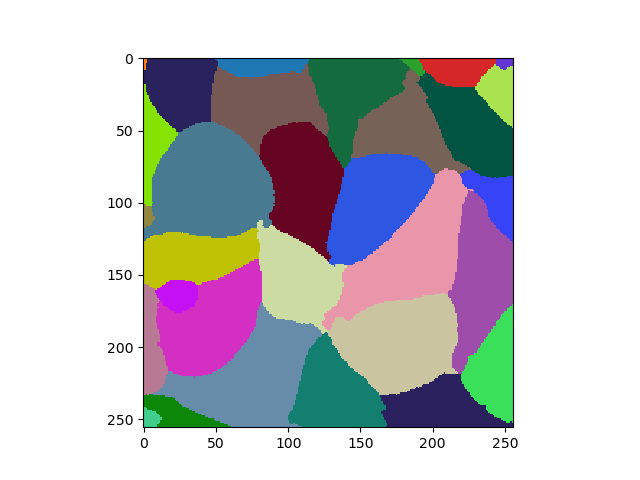

In [9]:
merged_labels = classifier.predict(labels=oversegmented, image=background_subtracted)
merged_labels